## Trabalho final da disciplina de introdução a IA

**Autores: José Felipe e Yure Talis**

### Motivação

Estresse e ansiedade são problemas corriqueiros na sociedade atual, podendo ser gatilho de um quadro de arritmia cardíaca ou como agravente deste. 

Para este trabalho utilizamos uma base de dados contendo fragmentos de eletrocardiogramas (ECG), para a identificação da presença ou não da doença.

A arritmia se caracteriza pela mudança brusca no ritmo cardíaco fazendo com que seja bombeando mais ou menos sengue do que o ideal, podendo  causar inicialmente cansaço, falta de ar, e em casos extremos, o óbto.

Essas mudanças do ritmo cardíaco podem ser identificadas no exame de eletrocardiograma, principal fonte de informação desse estudo.

In [1]:
# imports para analíse númerica
import numpy as np
import pandas as pd
# imports para analíse gráfica
import seaborn as sns
import matplotlib.pyplot as plt
# import para machine learning
from sklearn.model_selection import train_test_split
from sklearn import svm, naive_bayes, metrics, preprocessing
# imports para ignorar warnings
import warnings
warnings.filterwarnings('ignore')

### A base

A base de exames utilizada no teste pode ser encontrada em https://datahub.io/machine-learning/arrhythmia.

Contém informações sobre os pacientes e os exames realizados nos mesmos.

In [2]:
train_df = pd.read_csv('arrhythmia_csv.csv')

train_df.head()

,age,sex,height,weight,QRSduration,PRinterval,Q-Tinterval,Tinterval,Pinterval,QRS,...,chV6_QwaveAmp,chV6_RwaveAmp,chV6_SwaveAmp,chV6_RPwaveAmp,chV6_SPwaveAmp,chV6_PwaveAmp,chV6_TwaveAmp,chV6_QRSA,chV6_QRSTA,class
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7


### Limpeza da base

Removendo dados faltantes

In [3]:
print(train_df.shape)
train_df.isnull().sum().sort_values(ascending=False)

(452, 280)


J                             376
P                              22
T                               8
heartrate                       1
QRST                            1
class                           0
chV1_SPwave                     0
chV1_intrinsicReflecttions      0
chV1_RRwaveExists               0
chV1_DD_RRwaveExists            0
chV1_RPwaveExists               0
chV1_Swave                      0
chV1_DD_RPwaveExists            0
chV1_RTwaveExists               0
chV1_DD_RTwaveExists            0
chV2_Qwave                      0
chV2_Rwave                      0
chV2_Swave                      0
chV2_RPwave                     0
chV2_SPwave                     0
chV1_RPwave                     0
chAVF_DD_RTwaveExists           0
chV1_Rwave                      0
chV1_Qwave                      0
chV2_RRwaveExists               0
chAVF_RTwaveExists              0
chAVF_DD_RPwaveExists           0
chAVF_RPwaveExists              0
chAVF_DD_RRwaveExists           0
chAVF_RRwaveEx

As colunas 'J', 'P' e 'T' além de apresentarem o maior número de dados faltantes, são informações identificadoras, e não agregam ao teste, por isso serão descartadas. Os dados faltantes nas demais colunas somam um montante ínfimo em relação ao total, podendo ser feita a remoção destas linhas com células defeituosas. 

In [4]:
drop_columns = ['J', 'P', 'T']
train_df.drop(drop_columns, axis=1, inplace=True)

train_df.dropna(subset=['heartrate'], axis=0, inplace=True)
train_df.dropna(subset=['QRST'], axis=0, inplace=True)

train_df.isnull().sum().sort_values(ascending=False)

class                          0
chV1_DD_RPwaveExists           0
chV1_RPwave                    0
chV1_SPwave                    0
chV1_intrinsicReflecttions     0
chV1_RRwaveExists              0
chV1_DD_RRwaveExists           0
chV1_RPwaveExists              0
chV1_RTwaveExists              0
chV2_RRwaveExists              0
chV1_DD_RTwaveExists           0
chV2_Qwave                     0
chV2_Rwave                     0
chV2_Swave                     0
chV2_RPwave                    0
chV2_SPwave                    0
chV1_Swave                     0
chV1_Rwave                     0
chV1_Qwave                     0
chAVF_DD_RTwaveExists          0
chAVF_RTwaveExists             0
chAVF_DD_RPwaveExists          0
chAVF_RPwaveExists             0
chAVF_DD_RRwaveExists          0
chAVF_RRwaveExists             0
chAVF_intrinsicReflecttions    0
chAVF_SPwave                   0
chAVF_RPwave                   0
chAVF_Swave                    0
chAVF_Rwave                    0
          

Feita a limpeza em relação aos dados defeituosos. Poderiam ser adicionados valores fictícios a estas células vazias, porém essa decisão poderia afetar diretamente o resultado final.

### Checando correlação das classes com a classe alvo

Primeiro checando com o resultado em seu estado original (de 1 a 16). Nesse caso das 276 classes apenas 6 possuem correlação maior que 0.2 com o resultado final do exame.

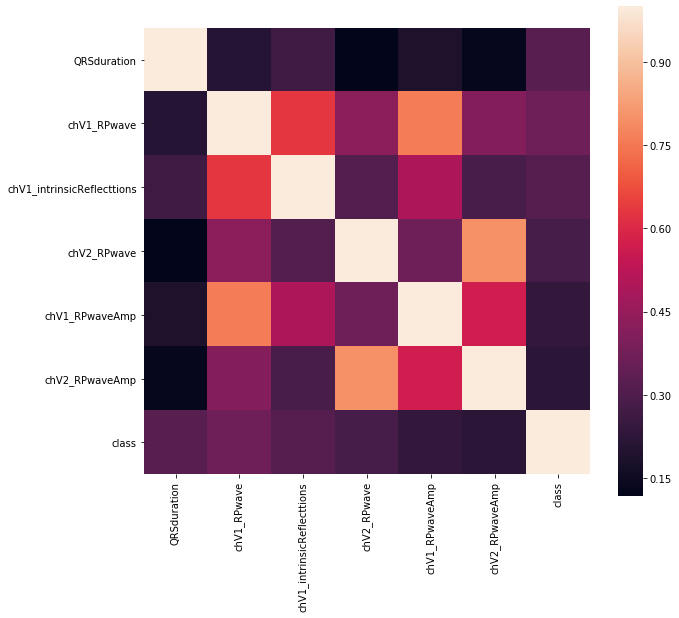

In [5]:
#correlação com dados crus

cols = train_df.corr(method='pearson').index[abs(train_df.corr()["class"])>0.2]
corr_matrix = np.corrcoef(train_df[cols].values.T)

f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(corr_matrix, square=True, yticklabels=cols.values, xticklabels=cols.values)

Dado que 1 sinaliza a ausência da doença no paciente e de 2 adiante seria o grau de arritmia daquele paciente na classe de saída, foi decidido atribuir valores binários para essa classe, sendo 0 a ausência de arritmia e 1 a presença. 

In [6]:
# transformando o valor de saída em binário

def class_to_b(x):
    if x == 1:
        return 0
    else:
        return 1

train_df['class'] = train_df['class'].apply(class_to_b)

train_df['class'].describe()

count    450.000000
mean       0.457778
std        0.498769
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: class, dtype: float64

Obtendo agora a correlação com saída binarizada.

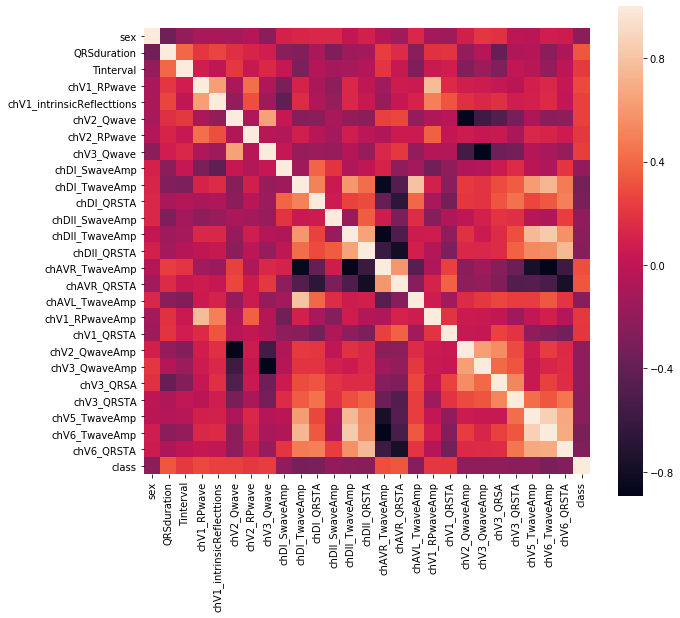

In [7]:
# correlação com dados da classe alvo binarizados

cols_bestcorr = train_df.corr(method='pearson').index[abs(train_df.corr()["class"])>0.2]
corr_matrix = np.corrcoef(train_df[cols_bestcorr].values.T)

f, ax = plt.subplots(figsize=(10, 9))
sns.heatmap(corr_matrix, square=True, yticklabels=cols_bestcorr.values, xticklabels=cols_bestcorr.values)

### Checando o balanceamento das classes

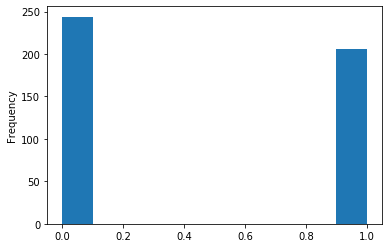

In [8]:
train_df['class'].plot.hist()

A classe do resultado tem valores próximos para a frequência de seus possíveis valores de saída.

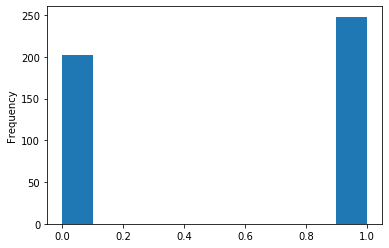

In [9]:
train_df['sex'].plot.hist()

De novo o número de homens e mulheres presentes na base são parecidos.

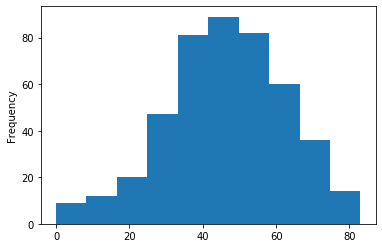

In [10]:
train_df['age'].plot.hist()

Pacientes com idades entre 30 e 60 anos são mais presentes na base, representando quase metade, os demais valores valores para idade apresentam menor frequência.

Os demais dados são valores contínuos e não é interessante checar seu balanceamento dado que os dados representam uma série temporal e é natural que seus valores variem no tempo.

### Divisão entre treino e teste

A base de dados foi dividida em 75% para treino e 25% teste de forma aleatória.

In [11]:
train_target = ['class']
train_data = []

for col in cols_bestcorr:
    if col != 'class':
        train_data.append(col)

X_train, X_test, y_train, y_test = train_test_split(train_df[train_data], train_df[train_target], test_size=0.25, random_state=0)

### Predição da classificação do paciente

Para realizar a classificação foram utilizados dois modelos, um SVM e um Naive Bayes.

Primeiro foi feito o teste levando em conta apenas as classes com melhor correlação com a classe de saída e esse foi o resultado obtido.

#### SVM

In [12]:
SVM_classifier = svm.SVC(kernel='poly', degree=3, C=50).fit(X_train, y_train)

y_predict_svm = SVM_classifier.predict(X_test)

print("accuracy:", round(SVM_classifier.score(X_test, y_test)*100, 2),'%')

cm_svm = metrics.confusion_matrix(y_test, y_predict_svm)
print("confusion matrix:\n", cm_svm)

print("f1 score:", round(metrics.f1_score(y_test, y_predict_svm), 2))
print("sensibility score:", round(metrics.precision_score(y_test, y_predict_svm), 2))
print("specificity score:", round(metrics.recall_score(y_test, y_predict_svm), 2))

accuracy: 68.14 %
confusion matrix:
 [[47 20]
 [16 30]]
f1 score: 0.63
sensibility score: 0.6
specificity score: 0.65


#### Naive Bayes

In [13]:
NB_classifier = naive_bayes.GaussianNB()
NB_classifier.fit(X_train, y_train)

y_predict_nb = NB_classifier.predict(X_test)

print("accuracy:", round(NB_classifier.score(X_test, y_test)*100,2),'%')

cm_nb = metrics.confusion_matrix(y_test, y_predict_nb)
print("confusion matrix:\n", cm_nb)

print("f1 score:", round(metrics.f1_score(y_test, y_predict_nb), 2))
print("sensibility score:", round(metrics.precision_score(y_test, y_predict_nb), 2))
print("specificity score:", round(metrics.recall_score(y_test, y_predict_nb), 2))

accuracy: 76.99 %
confusion matrix:
 [[63  4]
 [22 24]]
f1 score: 0.65
sensibility score: 0.86
specificity score: 0.52


### Aplicando os mesmos algoritmos agora considerando todas as colunas da base.

#### SVM

In [14]:
train_target = ['class']
train_data = []

for col in train_df.columns:
    if col != 'class':
        train_data.append(col)

X_train2, X_test2, y_train2, y_test2 = train_test_split(train_df[train_data], train_df[train_target], test_size=0.25, random_state=0)

SVM_classifier = svm.SVC(kernel='poly', degree=3, C=50).fit(X_train2, y_train2)

y_predict_svm2 = SVM_classifier.predict(X_test2)

print("accuracy:", round(SVM_classifier.score(X_test2, y_test2)*100, 2),'%')

cm_svm2 = metrics.confusion_matrix(y_test2, y_predict_svm2)
print("confusion matrix:\n", cm_svm2)

print("f1 score:", round(metrics.f1_score(y_test2, y_predict_svm2), 2))
print("sensibility score:", round(metrics.precision_score(y_test2, y_predict_svm2), 2))
print("specificity score:", round(metrics.recall_score(y_test2, y_predict_svm2), 2))

accuracy: 71.68 %
confusion matrix:
 [[49 18]
 [14 32]]
f1 score: 0.67
sensibility score: 0.64
specificity score: 0.7


#### Naive Bayes

In [15]:
NB_classifier = naive_bayes.GaussianNB()
NB_classifier.fit(X_train2, y_train2)

y_predict_nb2 = NB_classifier.predict(X_test2)

print("accuracy:", round(NB_classifier.score(X_test2, y_test2)*100,2),'%')

cm_nb2 = metrics.confusion_matrix(y_test2, y_predict_nb2)
print("confusion matrix:\n", cm_nb2)

print("f1 score:", round(metrics.f1_score(y_test2, y_predict_nb2), 2))
print("sensibility score:", round(metrics.precision_score(y_test2, y_predict_nb2), 2))
print("specificity score:", round(metrics.recall_score(y_test2, y_predict_nb2), 2))

accuracy: 70.8 %
confusion matrix:
 [[64  3]
 [30 16]]
f1 score: 0.49
sensibility score: 0.84
specificity score: 0.35


### Conclusão dos testes

Ao trabalhar com modelos de classificação nem sempre a correlação entre atributos pode significar benefício para o teste, as vezes o contrário pode acontecer, como pudemos notar no caso da SVM, já para o Naive Bayes Gaussiano, utilizar classes com maior correlação com a saída melhorou os valores de suas métricas.